In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

import helper_functions
reload(helper_functions)
from helper_functions import accuracy_rate, load_data, capacity, get_good_idx, get_slice, get_k_fold_cv_idx, get_x_sequences_rnn, train, get_all_accuracy_rates, allocate_x_batch_rnn, quantile_score, get_competition_preds

nn_type = 'rnn'
allocate_x_batch = allocate_x_batch_rnn
get_x_sequences = get_x_sequences_rnn


In [2]:
np.random.seed(2021)

case=3
x,x_time,y,y_time,time_dif,idx_offset = load_data(case)

# Index offset between start and end of training data for one single prediction
# i.e. number of quarters of an hour we wish to train on for each sample
pred_seq_len = 6*4+1


#i=1000
#print(target_time[i])
#print(x_time[i+idx_offset-pred_seq_len+1:i+idx_offset+1])

good_idx = get_good_idx(x,y,idx_offset,pred_seq_len)


print(x.shape)
print(y.shape)
print(x_time[0])
print(y_time[0])
print(len(good_idx))

torch.Size([164958, 16])
torch.Size([118382, 1])
2016-01-01 20:00:00
2017-05-01 00:00:00
111927


In [3]:
input_size = x.shape[1]
num_channels = input_size
hidden_size1 = 50
hidden_size2 = 50
out_size = 1

kernel_size = 7
stride = 3
padding = 3
conv_out_seq = round((pred_seq_len + 2*padding - kernel_size) / stride + 1)
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  
        
        #self.conv = nn.Conv1d(in_channels = input_size, 
        #                      out_channels = num_channels, 
        #                      kernel_size = kernel_size, 
        #                      stride=stride, 
        #                      padding=padding,
        #                      groups = input_size)
        self.lstm = nn.LSTM(input_size=num_channels,
                            hidden_size=hidden_size1,
                            num_layers=1,
                            batch_first=True, # batch_size x sequence_length x input_size
                            bias=True)
        self.gru = nn.GRU(input_size=num_channels,
                          hidden_size=hidden_size1,
                          num_layers=1,
                          batch_first=True, # batch_size x sequence_length x input_size
                          bias=True)
        #self.l1 = nn.Linear(in_features=pred_seq_len * hidden_size1,
        #                       out_features=hidden_size2,
        #                       bias=True)
        self.l_out = nn.Linear(in_features=pred_seq_len * hidden_size1,
                               out_features=out_size,
                               bias=True)
        
        self.act = nn.ReLU()
        
        
    def forward(self, x):
        #x = self.conv(x) ## remove this
        #x = x.reshape(-1, conv_out_seq, num_channels)
        
        #x, (h, c) = self.lstm(x)
        x, h = self.gru(x)
        # Is it necessary to have an activation function between each gru/lstm layer if we want to use more than 1?
        # Do they have their own activation functions?
        x = x.reshape(-1, pred_seq_len * hidden_size1)
        x = self.act(x)  
        x = self.l_out(x)
        return x


net = Net()
print(net)

optimizer = optim.Adam(net.parameters())
loss = nn.MSELoss()

Net(
  (lstm): LSTM(16, 50, batch_first=True)
  (gru): GRU(16, 50, batch_first=True)
  (l_out): Linear(in_features=1250, out_features=1, bias=True)
  (act): ReLU()
)


In [4]:

        
# setting hyperparameters and gettings epoch sizes
batch_size = 10000
num_epochs = 15
k_fold_size = 5

loss = nn.MSELoss()


q=0.3
def quantile_score_metric(y, y_pred): 
    return quantile_score(y,y_pred,q)
def accuracy_rate_metric(y, y_pred): 
    return accuracy_rate(y*capacity(case),y_pred*capacity(case),capacity(case))
def mseloss(*args): 
    return nn.MSELoss()(*args)
def maeloss(*args):
    return nn.L1Loss()(*args)
valid_metrics = [mseloss, maeloss, quantile_score_metric, accuracy_rate_metric]


train_loss, valid_loss = train(nn_type, x, y, net, num_epochs, batch_size, good_idx, k_fold_size, idx_offset, pred_seq_len, loss, valid_metrics)
valid_loss[0] = np.sqrt(valid_loss[0])

Epoch  0 : Training loss: 0.0729, 
Validation metrics: 
mseloss 0.0395 
maeloss 0.1465 
quantile_score_metric 0.0604 
accuracy_rate_metric 0.8012 

Epoch  1 : Training loss: 0.0340, 
Validation metrics: 
mseloss 0.0266 
maeloss 0.1190 
quantile_score_metric 0.0703 
accuracy_rate_metric 0.8370 

Epoch  2 : Training loss: 0.0256, 
Validation metrics: 
mseloss 0.0243 
maeloss 0.1249 
quantile_score_metric 0.0536 
accuracy_rate_metric 0.8442 

Epoch  3 : Training loss: 0.0219, 
Validation metrics: 
mseloss 0.0208 
maeloss 0.1010 
quantile_score_metric 0.0563 
accuracy_rate_metric 0.8557 

Epoch  4 : Training loss: 0.0206, 
Validation metrics: 
mseloss 0.0195 
maeloss 0.1019 
quantile_score_metric 0.0479 
accuracy_rate_metric 0.8604 

Epoch  5 : Training loss: 0.0196, 
Validation metrics: 
mseloss 0.0188 
maeloss 0.0976 
quantile_score_metric 0.0504 
accuracy_rate_metric 0.8629 

Epoch  6 : Training loss: 0.0189, 
Validation metrics: 
mseloss 0.0184 
maeloss 0.0963 
quantile_score_metric 0.

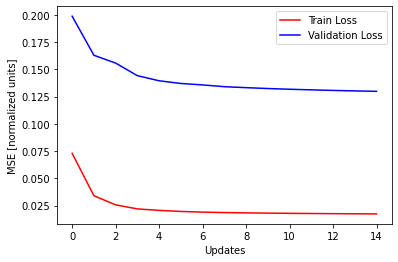

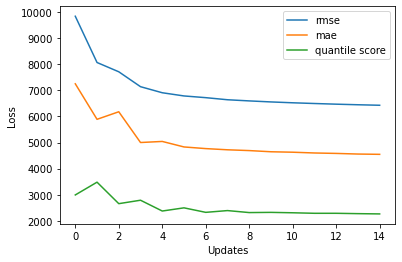

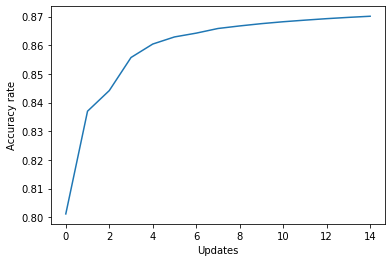

In [5]:
epoch = np.arange(len(train_loss))
plt.figure()
plt.plot(epoch, train_loss, 'r', epoch, valid_loss[0, :], 'b')
plt.legend(['Train Loss','Validation Loss'])
plt.xlabel('Updates'), plt.ylabel('MSE [normalized units]')
plt.show()

plt.figure()
plt.plot(epoch, capacity(case)*np.array(valid_loss[:-1]).T)
plt.legend(['rmse','mae','quantile score'])
plt.xlabel('Updates'), plt.ylabel('Loss')
plt.show()

plt.figure()
plt.plot(epoch, valid_loss[-1])
plt.xlabel('Updates'), plt.ylabel('Accuracy rate')
plt.show()


In [6]:
x_batch = allocate_x_batch(len(good_idx), input_size, pred_seq_len)
predictions = net(get_x_sequences(good_idx, x_batch, idx_offset, pred_seq_len, x)).detach().numpy()

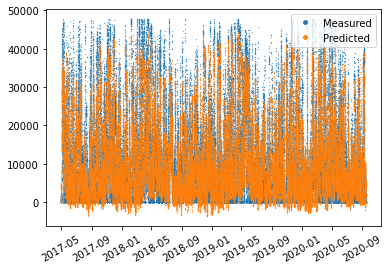

In [7]:
plt.plot(y_time[good_idx], capacity(case)*y[good_idx].detach().numpy(), '.', markersize=0.5, label = 'Measured')
plt.plot(y_time[good_idx], capacity(case)*predictions,'.', markersize=0.5, label = 'Predicted')
lgnd = plt.legend(markerscale=15)    
plt.xticks(rotation=30)
plt.show()

In [8]:
x_batch = allocate_x_batch(96, input_size, pred_seq_len)
accuracies, times = get_all_accuracy_rates(net, x, y, y_time, x_batch, get_x_sequences, good_idx, idx_offset, pred_seq_len, case)

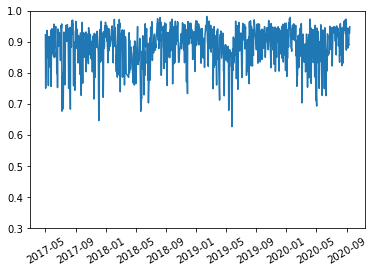

Mean accuracy rate 0.88970566


In [9]:
plt.plot(times, accuracies)
plt.xticks(rotation=30)
plt.ylim(0.3,1)
plt.show()
print('Mean accuracy rate', np.mean(accuracies))

In [10]:
day=0
save=False
predictions = get_competition_preds(day,case,get_x_sequences,allocate_x_batch,input_size,pred_seq_len,net,save)